In [2]:
import numpy as np
import scipy
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import matplotlib as mpl
import matplotlib.pyplot as plt
import bspy

# ODE \#5

### $$y''(t)=a(t)y(t)+b(t)y'(t)+c(t),\qquad y(0)=1,\qquad y(1)=-1$$

### Choose $a(t)=5t^2-200$, $b(t)=5-10t-5t^2$, and $c(t)=\cos t + 3t + 1$

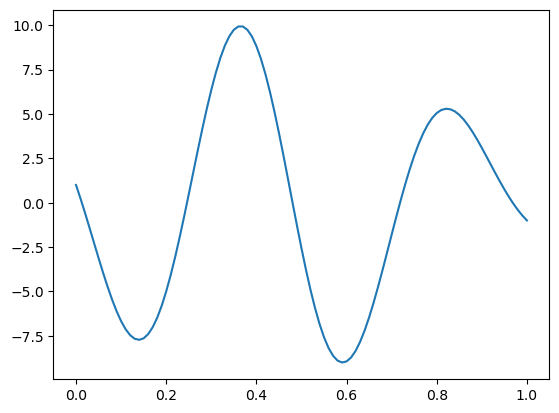

In [27]:
#set parameters
degree = 3
nknots = 300 #interior knots

#create knot vector
knots = np.linspace(0.0, 1.0, nknots + 2)
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]]) # add extra knots at beginning and end
#print("knots:", knots)


#initialize order and dimension
order = degree + 1
n = len(knots) - order #dimension
#print("dimensions:", n)


collocationpoints = np.linspace(0.0, 1.0, n - 2)
#print("collocation points:", collocationpoints)

#initialize collocation matrix
collocation = np.zeros((n, n))
#print("initialized collocation array:", collocation)



#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 0.0 
ix = np.searchsorted(knots, 0.0, side = 'right')
ix = min(ix, n)
#print("index:", ix)

#fill collocation matrix with Bspline values at 0.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 0.0)
collocation[0, ix - order : ix] = bvalues
#print("initiallized collocation:", collocation)


#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 1.0 
ix = np.searchsorted(knots, 1.0, side = 'right')
ix = min(ix, n)
#print("index:", ix)

#fill collocation matrix with Bspline values at 1.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 1.0)
collocation[-1, ix - order : ix] = bvalues



for irow, t in enumerate(collocationpoints):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)

    a = 5 * (t ** 2) - 200
    b = 5 - (10 * t) - 5 * (t ** 2)
    c = np.cos(t) + (3 * t) + 1
    
    #calculate Bspline and derivative at t
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    bvalues2p = bspy.Spline.bspline_values(ix, knots, order, t, 2)
    #print("t:", t,"index:", ix, "second deriv bval:", bvalues2p, "bval:", bvalues)
    
    #from the irow value after boundary condition (irow) insert y'' - y
    collocation[irow + 1, ix - order : ix] = bvalues2p - (a * bvalues) - (b * bvaluesp) - c
    #print("collocation:", collocation)
    
# Create the right hand side
rhs = np.zeros((n,))
rhs[-1] = -1.0
rhs[0] = 1.0
#print("rhs:", rhs)

# Solve the linear system
lupiv = scipy.linalg.lu_factor(collocation)
alpha = scipy.linalg.lu_solve(lupiv, rhs)
alpha

#create spline function
u = bspy.Spline(1, 1, [order], [n], [knots], [alpha])
u(0.0), u(0.5), u(1.0)

#print("collocation", collocation, "*", "alpha", alpha, "=", "rhs", rhs)


#plot
plt.plot(*u.graph()(np.linspace(0.0,1.0,101)))
tvals = np.linspace(0, 1, 100)
#plt.axis('equal')
plt.show()